# Preparation

<b>Load Libraries</b>

In [2]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

# decomposition
from sklearn.decomposition import PCA

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# mlflow
import mlflow
from mlflow.models import infer_signature, infer_pip_requirements

# others
import re, os, uuid, pickle
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# user-defined modules
##
cwd = os.getcwd()
os.chdir('../../../')

##
from src.mlflow.mlflow_usr_defined import MLflowModel

##
os.chdir(cwd)

In [3]:
# model's type separation
parametric_models = ['LR']
non_parametric_models = ['KNN', 'SVM', 'CART']
ensample_models = ['ET', 'RF', 'GB', 'LGBM', 'XGB']

<b>Load Dataset</b>

In [4]:
# dataset
df_base = pd.read_csv('../../../storage/data/cleaned/train.csv')

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

In [5]:
# cross validation
##
arr = df_base.values
le = LabelEncoder()

##
X, y = arr[:, :-1], le.fit_transform(arr[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

<b>MLflow</b>

In [6]:
# server connection
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [7]:
# experiment creation & conneting
experiment_name = 'Features Engineering'
try:
    mlflow.create_experiment(
        name=experiment_name, 
        artifact_location='storage/.mlflow/.artifact_store'
    )
    mlflow.set_experiment(
        experiment_name=experiment_name
    )
except:
    print(f'\'{experiment_name}\' has already existed.')
    mlflow.set_experiment(
        experiment_name=experiment_name
    )

'Features Engineering' has already existed.


<b>User-Defined Functions</b>

In [8]:
# parsed names
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [9]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVM', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [29]:
# resamplers
def load_resamplers() -> list:
    resamplers = []
    resamplers.append(('ROS', RandomOverSampler(sampling_strategy='minority')))
    resamplers.append(('SMOTE', SMOTE(sampling_strategy='minority')))
    resamplers.append(('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))))
    resamplers.append(('SMOTETomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))))

    return resamplers

In [11]:
# kflold results
def get_kfold_results(models: list, X: np.ndarray, y: np.ndarray) -> dict:
    ##
    kfold_results = dict()
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        kfold_results[name] = cv_results

    return kfold_results

In [12]:
# selected models
def get_selected_base_models(names_to_choose: list) -> list:
    models = load_base_models()
    selected_models = [(name, model) for name, model in models if name in names_to_choose]

    return selected_models

In [13]:
# kfold visualization
def plot_kfold_results(kfold_results: dict):
    ##
    data_to_plot = pd.DataFrame(kfold_results)

    ##
    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

In [14]:
# dump models
def dump_model(model, path):
    with open(path, 'wb') as output:
        pickle.dump(
            obj=model, file=output
        )

<b>User-Defined Classes</b>

In [15]:
# class SFS Base
class BaseUserDefinedTransformer(BaseEstimator, TransformerMixin):
    ## 
    def __init__(self, 
                 ohe=None, other_encoders=None,
                 scaling: list=[], factor_analysis: list=[]) -> None:
        ###
        self.scaling, self.factor_analysis = scaling, factor_analysis
        ### 
        self.ohe, self.other_encoders = ohe, other_encoders


    ##
    def _check_ndim(self, X: np.ndarray) -> tuple[np.ndarray, int]:
        ###
        if X.ndim == 2:
            X_ = X
            num_iters = X.shape[1]
        else:
            X_ = X.reshape(-1, 1)
            num_iters = 1

        return X_, num_iters
    
    ##
    def _category_detection(self, X: np.ndarray) -> tuple[list, list, np.ndarray]:
        ###
        num_idxes, cat_idxes = [], []

        ### check dimension
        X_, num_iters = self._check_ndim(X=X)

        ###
        for i in range(num_iters):
            try:
                X_[:1, i].astype(float)
                num_idxes.append(i)
            except:
                cat_idxes.append(i)
        
        return num_idxes, cat_idxes, X_
    
    ##
    def _get_transformers(self, cat_idxes: list=[], num_idxes: list=[]) -> list:
        if len(num_idxes) == 0:
            transformers = self.cat_pro
        elif len(cat_idxes) == 0:
            transformers = self.num_pro
        else:
            transformers = self.num_pro + self.cat_pro

        return transformers 
    
    ## 
    def fit(self, X: np.ndarray, y=None):
        ###
        transformers = self._get_transformers(self.cat_idxes, self.num_idxes)
        self.ct = ColumnTransformer(transformers, remainder='passthrough')
        self.ct.fit(self.X_fit_)

        return self
    
    ##
    def transform(self, X: np.ndarray, y=None):
        X_, _ = self._check_ndim(X=X)

        return self.ct.transform(X=X_)

In [16]:
# Onehot_Scaling_Pca
class SFS_OSP(BaseUserDefinedTransformer):
    def fit(self, X: np.ndarray, y=None):
        ###
        self.num_idxes, self.cat_idxes, self.X_fit_ = self._category_detection(X)

        ###
        steps = self.scaling + self.factor_analysis
        self.num_pro = [('num_pro', Pipeline(steps), self.num_idxes)]

        self.cat_pro = [('cat_pro', self.ohe, self.cat_idxes)]

        ###
        super().fit(X=X)
        
        return self

# 1. Baseline Evaluation

In [21]:
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

# base models
base_models = load_base_models()

## encoding
encoding = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = []
for name, model in base_models:
    steps = [('transformers', ColumnTransformer(encoding, remainder='passthrough')), 
             (name, model)]
    pipelines.append(
        (name, Pipeline(steps))
    )

## kfold results
kfold_results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.13228050685782308 (0.0541376961381269)
KNN: 0.3590482148333225 (0.08163408925075537)
SVM: 0.0 (0.0)
CART: 0.7251733262700119 (0.05919356179465921)
ET: 0.5006997964528093 (0.07899622854148063)
RF: 0.6668687236299438 (0.0920386680083268)
GB: 0.763119374378915 (0.05614856452888277)
LGBM: 0.7904782196037831 (0.052733861062937704)
XGB: 0.7788322510027165 (0.056953790262783334)


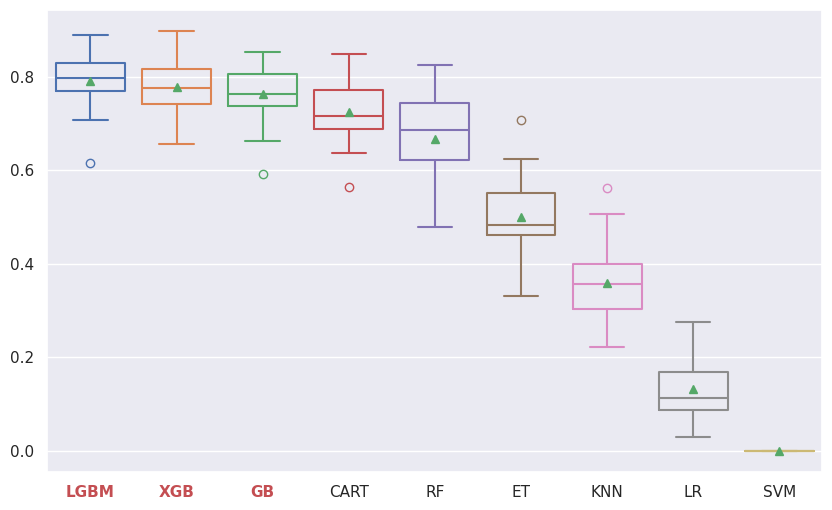

In [22]:
# visualizations
plot_kfold_results(
    kfold_results=kfold_results
)

In [23]:
# 
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## base model
models = load_base_models()

## encoding
ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## mlflow
for name, pipeline in pipelines:
    ###
    pipeline.fit(X_train, y_train)

    ###
    val_predictions = pipeline.predict(X_test)
    val_fbeta = fbeta_score(
        y_true=y_test, y_pred=val_predictions, 
        beta=2
    )

    ### mlflow
    with mlflow.start_run():
        ####
        mlflow.set_tags(
            {
                'pre_pro': 'ohe', 
                'base_model': name,
                'beta_f': 2
            }
        )

        ####
        mlflow.log_metrics(
            {
                'avg_fbeta': kfold_results[name].mean(), 
                'val_fbeta': val_fbeta
            }
        )

        ####
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path='model'
        )

In [ ]:
# pip requirements for LGBM
run_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LGBM'"
)['run_id'][0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{run_id}/model', 
    flavor='pyfunc'
)
pip_requirements.extend(['pickle==4.0', 'mlxtend==0.23.1'])
pip_requirements

# 2. Encoding && Scaling

<b>OneHot && Standardization</b>

In [17]:
# artifacts' path
artifacts_path = dict()
artifacts_path['feature_selector'] = '../../../storage/.notebook/ohe_std.pkl'
artifacts_path['model'] = f'../../../storage/.notebook/{str(uuid.uuid4())}.pkl'

In [28]:
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers: standardize
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', StandardScaler())]
)
## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
dump_model(
    model=sfs, 
    path=artifacts_path['feature_selector']
)

## save
pipeline.fit(sfs.transform(X_train), y_train)
dump_model(
    model=pipeline, 
    path=artifacts_path['model']
)


[2024-08-07 10:46:13] Features: 1/19 -- score: 0.2381489118845433
[2024-08-07 10:46:16] Features: 2/19 -- score: 0.42408191254368577
[2024-08-07 10:46:35] Features: 3/19 -- score: 0.5754211684925191
[2024-08-07 10:46:54] Features: 4/19 -- score: 0.6225729598342019
[2024-08-07 10:47:12] Features: 5/19 -- score: 0.6584611009627147
[2024-08-07 10:47:37] Features: 6/19 -- score: 0.66052986385995
[2024-08-07 10:48:01] Features: 7/19 -- score: 0.6617499533205715
[2024-08-07 10:48:18] Features: 8/19 -- score: 0.6601361994499585
[2024-08-07 10:48:36] Features: 9/19 -- score: 0.7311445443588926
[2024-08-07 10:48:53] Features: 10/19 -- score: 0.7990904116019475
[2024-08-07 10:49:08] Features: 11/19 -- score: 0.8020770922467613
[2024-08-07 10:49:39] Features: 12/19 -- score: 0.8020770922467613
[2024-08-07 10:49:40] Features: 13/19 -- score: 0.8005928428259913
[2024-08-07 10:49:55] Features: 14/19 -- score: 0.8008545466925517
[2024-08-07 10:50:09] Features: 15/19 -- score: 0.8014141696172937
[202

In [34]:
# model logging
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

## mlflow
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pre_pro': 'ohe_std', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'beta_f': 2
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='model', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=pip_requirements
    )

2024/08/07 11:01:32 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


<b>OneHot && PowerTransformation</b>

In [19]:
# artifacts's path
artifacts_path['feature_selector'] = '../../../storage/.notebook/ohe_yeojohnson.pkl'
artifacts_path['model'] = f'../../../storage/.notebook/{str(uuid.uuid4())}.pkl'

In [20]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', PowerTransformer(method='yeo-johnson', standardize=True))]
)

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
dump_model(
    model=sfs, 
    path=artifacts_path['feature_selector']
)

## save
pipeline.fit(sfs.transform(X_train), y_train)
dump_model(
    model=pipeline, 
    path=artifacts_path['model']
)


[2024-08-07 15:50:12] Features: 1/19 -- score: 0.23735039060793678
[2024-08-07 15:50:35] Features: 2/19 -- score: 0.42582041867224146
[2024-08-07 15:51:01] Features: 3/19 -- score: 0.5774183734798274
[2024-08-07 15:51:40] Features: 4/19 -- score: 0.6238530809892006
[2024-08-07 15:52:17] Features: 5/19 -- score: 0.6581735954421309
[2024-08-07 15:52:48] Features: 6/19 -- score: 0.6586658214158743
[2024-08-07 15:53:17] Features: 7/19 -- score: 0.7236601632131298
[2024-08-07 15:53:41] Features: 8/19 -- score: 0.8006204713894784
[2024-08-07 15:54:04] Features: 9/19 -- score: 0.8043225746011307
[2024-08-07 15:54:26] Features: 10/19 -- score: 0.8054731887556635
[2024-08-07 15:54:47] Features: 11/19 -- score: 0.8090817933195367
[2024-08-07 15:55:06] Features: 12/19 -- score: 0.8090817933195367
[2024-08-07 15:55:24] Features: 13/19 -- score: 0.8045225948431872
[2024-08-07 15:55:43] Features: 14/19 -- score: 0.8039057746144053
[2024-08-07 15:55:59] Features: 15/19 -- score: 0.8016731581905101
[

In [21]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pre_pro': 'ohe_yeojohnson', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'beta_f': 2
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='model', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=pip_requirements
    )

2024/08/07 15:58:24 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


<b>OneHot && QuantileTransformatin</b>

In [22]:
# artifacts' path 
artifacts_path['feature_selector'] = '../../../storage/.notebook/ohe_quantile.pkl'
artifacts_path['model'] = f'../../../storage/.notebook/{str(uuid.uuid4())}.pkl'

In [23]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer(output_distribution='normal'))]
)

## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
dump_model(
    model=sfs, 
    path=artifacts_path['feature_selector']
)

##
pipeline.fit(sfs.transform(X_train), y_train)
dump_model(
    model=pipeline, 
    path=artifacts_path['model']
)


[2024-08-07 15:59:57] Features: 1/19 -- score: 0.23645564657585305
[2024-08-07 16:00:29] Features: 2/19 -- score: 0.4220726154953954
[2024-08-07 16:01:05] Features: 3/19 -- score: 0.5765331982466577
[2024-08-07 16:01:46] Features: 4/19 -- score: 0.623949584845233
[2024-08-07 16:02:38] Features: 5/19 -- score: 0.6516358179604785
[2024-08-07 16:03:24] Features: 6/19 -- score: 0.6626550158392714
[2024-08-07 16:04:06] Features: 7/19 -- score: 0.7365166966759648
[2024-08-07 16:04:53] Features: 8/19 -- score: 0.7948174207609834
[2024-08-07 16:05:38] Features: 9/19 -- score: 0.804334197354321
[2024-08-07 16:06:21] Features: 10/19 -- score: 0.804334197354321
[2024-08-07 16:07:11] Features: 11/19 -- score: 0.8043036212839862
[2024-08-07 16:07:58] Features: 12/19 -- score: 0.80524396203364
[2024-08-07 16:08:34] Features: 13/19 -- score: 0.8029602268374475
[2024-08-07 16:09:06] Features: 14/19 -- score: 0.8045730508613071
[2024-08-07 16:09:40] Features: 15/19 -- score: 0.8056417463137108
[2024-0

In [24]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ###
    mlflow.set_tags(
        {
            'pre_pro': 'ohe_quantile', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'beta_f': 2
        }
    )

    ###
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ###
    mlflow.pyfunc.log_model(
        artifact_path='model', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=pip_requirements
    )

2024/08/07 16:11:05 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


# 3. Encoding && Scaling && PCA

<b>OneHot && QuantileTransform && PCA(90%)

In [26]:
# artifacts' path
artifacts_path['feature_selector'] = '../../../storage/.notebook/ohe_quantile_pca.pkl'
artifacts_path['model'] = f'../../../storage/.notebook//{str(uuid.uuid4())}.pkl'

In [27]:
#
## warnings
from warnings import simplefilter
simplefilter(action='ignore')

##
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', QuantileTransformer())], factor_analysis=[('pca', PCA(n_components=0.9))]
)

##
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## 
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forwanrd
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)
dump_model(
    model=sfs, 
    path=artifacts_path['feature_selector']
)

##
pipeline.fit(sfs.transform(X_train), y_train)
dump_model(
    model=pipeline, 
    path=artifacts_path['model']
)


[2024-08-07 16:16:03] Features: 1/19 -- score: 0.23651254705174793
[2024-08-07 16:16:32] Features: 2/19 -- score: 0.40588183110059217
[2024-08-07 16:17:22] Features: 3/19 -- score: 0.5457852406831913
[2024-08-07 16:17:41] Features: 4/19 -- score: 0.6007576151755125
[2024-08-07 16:18:17] Features: 5/19 -- score: 0.6201483829446932
[2024-08-07 16:18:53] Features: 6/19 -- score: 0.648909468722092
[2024-08-07 16:19:32] Features: 7/19 -- score: 0.6787024518104643
[2024-08-07 16:20:12] Features: 8/19 -- score: 0.6831594533511679
[2024-08-07 16:20:52] Features: 9/19 -- score: 0.7182931025993571
[2024-08-07 16:21:31] Features: 10/19 -- score: 0.7180892090239053
[2024-08-07 16:22:10] Features: 11/19 -- score: 0.7106651408595411
[2024-08-07 16:22:45] Features: 12/19 -- score: 0.7145689716125239
[2024-08-07 16:23:19] Features: 13/19 -- score: 0.7120427665208019
[2024-08-07 16:23:50] Features: 14/19 -- score: 0.6374091794970835
[2024-08-07 16:24:17] Features: 15/19 -- score: 0.6286493388232757
[2

In [28]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(X_test))
val_fbeta = fbeta_score(
    y_true=y_test, y_pred=val_predictions, 
    beta=2
)

##
with mlflow.start_run():
    ##
    mlflow.set_tags(
        {
            'pre_pro': 'ohe_quantile_pca(0.9)', 
            'base_model': 'LGBM', 
            'feature_selection': 'true', 
            'beta_f': 2
        }
    )

    ##
    mlflow.log_metrics(
        {
            'avg_fbeta': sfs.k_score_, 
            'val_fbeta': val_fbeta
        }
    )

    ##
    mlflow.pyfunc.log_model(
        artifact_path='model', 
        python_model=MLflowModel(), 
        artifacts=artifacts_path, 
        signature=infer_signature(X_train), 
        pip_requirements=pip_requirements
    )

2024/08/07 16:26:37 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


# 4. Encoding && Scaling && Resampling

<b>OneHot && QuantileTrasnform && Resamlings</b>

In [18]:
# feature selector
artifacts_path['feature_selector'] = '../../../storage/.notebook/ohe_quantile.pkl'
with open(artifacts_path['feature_selector'], 'rb') as f:
    feature_selector = pickle.load(f)
selected_X_train = feature_selector.transform(X_train)

In [31]:
## resamplers
resamplers = load_resamplers()
results = dict()

##
for name, resampler in resamplers:
    ### transformer
    transformers = SFS_OSP(
        ohe=OneHotEncoder(drop='first', sparse_output=False), 
        scaling=[('scaling', QuantileTransformer(output_distribution='normal'))]
    )

    ### base model
    base_model = get_selected_base_models(
        names_to_choose=['LGBM']
    )

    ### pipeline
    pipeline = Pipeline(
        steps=[('transformers', transformers), (name, resampler)] + base_model
    )

    ### kfold result
    kfold_result = cross_val_score(
        estimator=pipeline, 
        X=selected_X_train, y=y_train, 
        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
        scoring=make_scorer(fbeta_score, beta=2)
    )
    print(f'{name}: {kfold_result.mean()} ({kfold_result.std()})')
    results[name] = kfold_result
    
    ### fitted pipeline
    pipeline = pipeline.fit(selected_X_train, y_train)
    dump_model(
        model=pipeline, 
        path=f'../../../storage/.notebook/{str(uuid.uuid4())}.pkl'
    )

    ### make predictions on unseen data
    val_predictions = pipeline.predict(feature_selector.transform(X_test))
    val_fbeta = fbeta_score(
        y_true=y_test, y_pred=val_predictions, 
        beta=2
    )

    ## mlflow
    with mlflow.start_run():
        #### tags 
        mlflow.set_tags(
            {
                'pre_pro': f'ohe_quantile_{name.lower()}', 
                'base_model': 'LGBM', 
                'feature_selection': 'true', 
                'beta_f': 2
            }
        )

        #### metrics
        mlflow.log_metrics(
            {
                'avg_fbeta': kfold_result.mean(),
                'val_fbeta': val_fbeta
            }
        )

        ####
        mlflow.pyfunc.log_model(
            artifact_path='model', 
            python_model=MLflowModel(), 
            artifacts=artifacts_path, 
            signature=infer_signature(X_train), 
            pip_requirements=pip_requirements
        )

ROS: 0.8258595839393255 (0.05050340003993136)


/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/08/07 17:00:24 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


SMOTE: 0.8209688844102221 (0.0546782408362376)


2024/08/07 17:00:47 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.
/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


SMOTEENN: 0.8064893497050731 (0.04401758099298881)


2024/08/07 17:00:39 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.
/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


SMOTETomek: 0.8136248915951773 (0.05664816877337844)


2024/08/07 17:00:48 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.
2024/08/07 17:00:48 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.
/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before

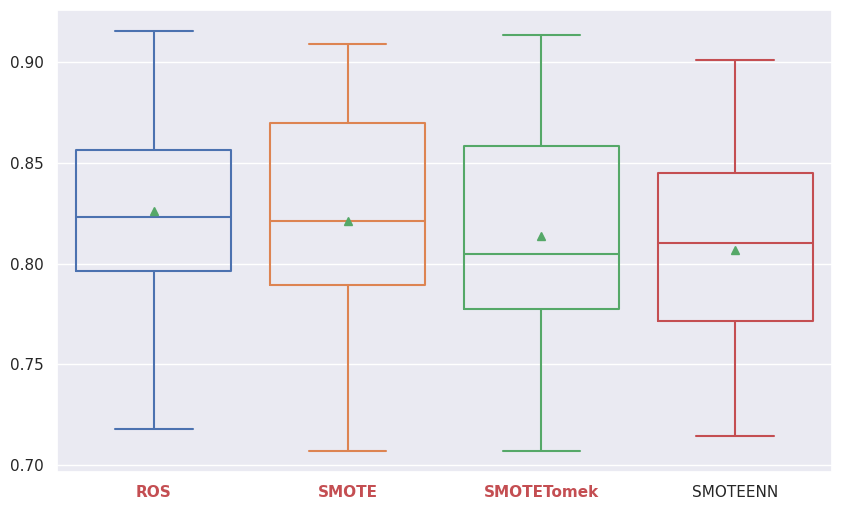

In [32]:
# plotting kfold results
plot_kfold_results(kfold_results=results)

# 5. Finalize Model

In [36]:
# load model
run_id = mlflow.search_runs(
    filter_string="metrics.avg_fbeta > 0.8", 
    order_by=["metrics.agv_fbeta DESC", "metrics.val_fbeta DESC"],
    search_all_experiments=True
)['run_id'][0]

model = mlflow.pyfunc.load_model(
    model_uri=f'runs:/{run_id}/model'
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1096
           1       0.92      0.84      0.88       179

    accuracy                           0.97      1275
   macro avg       0.94      0.92      0.93      1275
weighted avg       0.97      0.97      0.97      1275



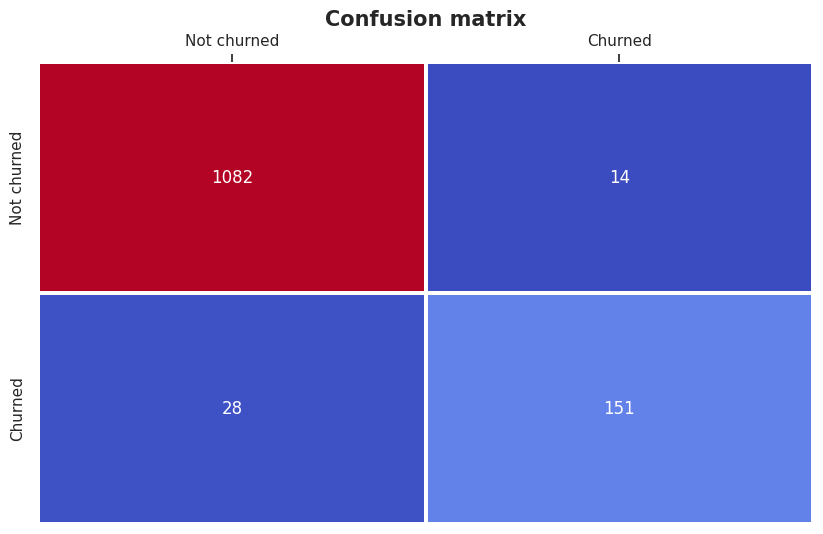

In [52]:
# make predictions on unseen data
## classfication report
predictions = model.predict(X_test)
print(classification_report(
    y_true=y_test, y_pred=predictions
))

## confusion matrix
data = confusion_matrix(
    y_true=y_test, y_pred=predictions
)
g = sns.heatmap(
    data=data, 
    annot=True, fmt='.0f', 
    cmap='coolwarm', cbar=False, 
    square=False,
    linewidths=1.5
)
g.set_yticklabels(
    labels=['Not churned', 'Churned']
)
g.set_xticklabels(
    labels=['Not churned', 'Churned']
)
g.xaxis.tick_top()
g.set_title(
    label='Confusion matrix', 
    fontdict=dict(
        weight='bold', 
        size=15
    )
)
plt.show()